### Run in collab
<a href="https://colab.research.google.com/github/racousin/data_science_practice/blob/master/website/public/modules/module13/exercise/module13_exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install swig==4.2.1
!pip install gymnasium==0.29.1

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# module13_exercise2 : ML - Arena <a href="https://ml-arena.com/viewcompetition/5" target="_blank"> FrozenLake Competition</a>

### Objective
Get at list an agent running on ML-Arena <a href="https://ml-arena.com/viewcompetition/5" target="_blank"> FrozenLake Competition</a> with mean reward upper than 0.35 (ie 35%)


You should submit an agent file named `agent.py` with a class `Agent` that includes at least the following attributes:

In [ ]:
class Agent:
    def __init__(self, env):
        self.env = env

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        action = self.env.action_space.sample() # your logic here
        return action

### Description

The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world [7,7].

Holes in the ice are distributed in set locations.

The player makes moves until they reach the goal or fall in a hole.

Each run will consist of 10 attempts to cross the ice. The reward will be the total amount accumulated during those trips. For example, if your agent reaches the goal 3 times out of 10, its reward will be 3.

The environment is based on :

In [ ]:
env = gym.make('FrozenLake-v1', map_name="8x8")

In [ ]:
def run_experiment_episode_train(env, agent, nb_episode, is_train=True):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()[0]
        terminated, truncated = False, False
        rews = []
        while not (terminated or truncated):
            action = agent.choose_action(state)
            current_state = state
            state, reward, terminated, truncated, info = env.step(action)
            if is_train:
                agent.train(current_state, action, reward, state, terminated or truncated)
            rews.append(reward)
        rewards[i] = sum(rews)
    return rewards

In [ ]:
def get_epislon_greedy_action_from_q(Q_s,epsilon):
    if np.random.rand() > epsilon:
        return np.argmax(Q_s)
    else:
        action = env.action_space.sample()
        return action

In [ ]:
class Agent():
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = np.random.rand(env.observation_space.n, env.action_space.n)

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        action = get_epislon_greedy_action_from_q(self.q[observation], self.epsilon)
        return action

    def qsa_update(self, state, action, reward, next_state, done):
        target = reward + (0 if done else self.gamma * np.max(self.q[next_state]))
        td_error = target - self.q[state, action]
        self.q[state, action] += self.alpha * td_error

    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)

In [ ]:
class DecayAgent():
    def __init__(self, env, gamma=0.99, epsilon=1.0, alpha=0.1, epsilon_decay=0.99, min_epsilon=0.0):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q = np.random.rand(env.observation_space.n, env.action_space.n)

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        return get_epislon_greedy_action_from_q(self.q[observation], self.epsilon)

    def qsa_update(self, state, action, reward, next_state, done):
        target = reward + (0 if done else self.gamma * np.max(self.q[next_state]))
        td_error = target - self.q[state, action]
        self.q[state, action] += self.alpha * td_error

    def epsilon_decay_exponential(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        self.epsilon_decay_exponential()

In [ ]:
agent = Agent(env)
decay_agent_1 = DecayAgent(env)
decay_agent_2 = DecayAgent(env, min_epsilon=0.01)

rewards_agent = run_experiment_episode_train(env, agent, 5000)
rewards_decay_agent1 = run_experiment_episode_train(env, decay_agent_1, 5000)
rewards_decay_agent2 = run_experiment_episode_train(env, decay_agent_2, 5000)

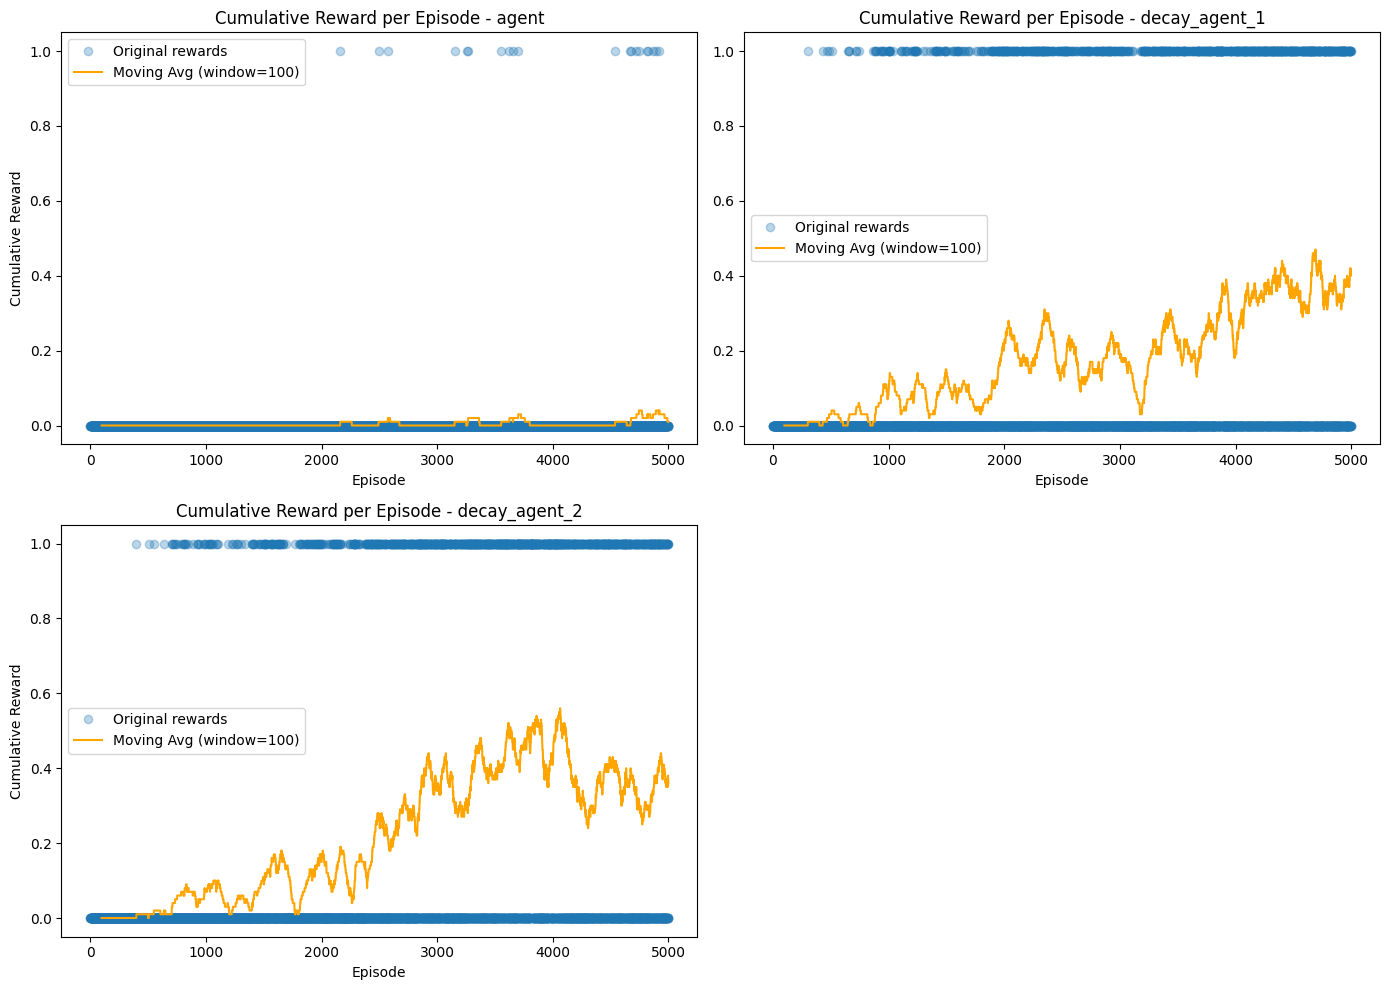

In [ ]:
window_size = 100
moving_avg = np.convolve(rewards_agent, np.ones(window_size) / window_size, mode='valid')
moving_avg_decay1 = np.convolve(rewards_decay_agent1, np.ones(window_size) / window_size, mode='valid')
moving_avg_decay2 = np.convolve(rewards_decay_agent2, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(rewards_agent, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_agent)), moving_avg, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - agent')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(rewards_decay_agent1, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_decay_agent1)), moving_avg_decay1, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - decay_agent_1')
plt.xlabel('Episode')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(rewards_decay_agent2, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_decay_agent2)), moving_avg_decay2, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - decay_agent_2')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.tight_layout()
plt.show()

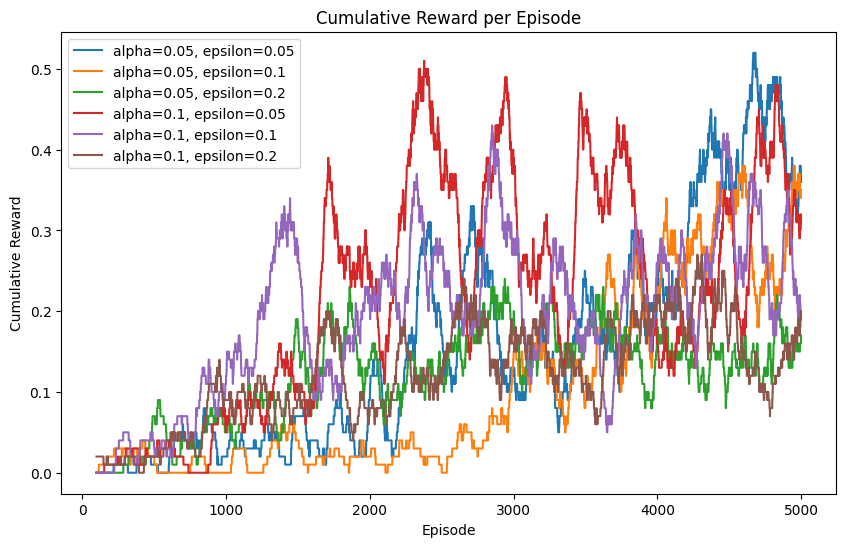

In [ ]:
nb_episode = 5000
alphas = [.05, .1]
epsilons = [.05, .1, .2]
N=len(alphas)*len(epsilons)

plt.figure(figsize=(10, 6))

i=0
for a in alphas:
      for eps in epsilons:
            test_agent = Agent(env, epsilon = eps, alpha = a)
            rewards = run_experiment_episode_train(env, test_agent, nb_episode)
            window_size = 100
            moving_avg = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
            i +=1
            plt.plot(range(window_size - 1, len(rewards)), moving_avg, label=f'alpha={a}, epsilon={eps}')

plt.title(f'Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

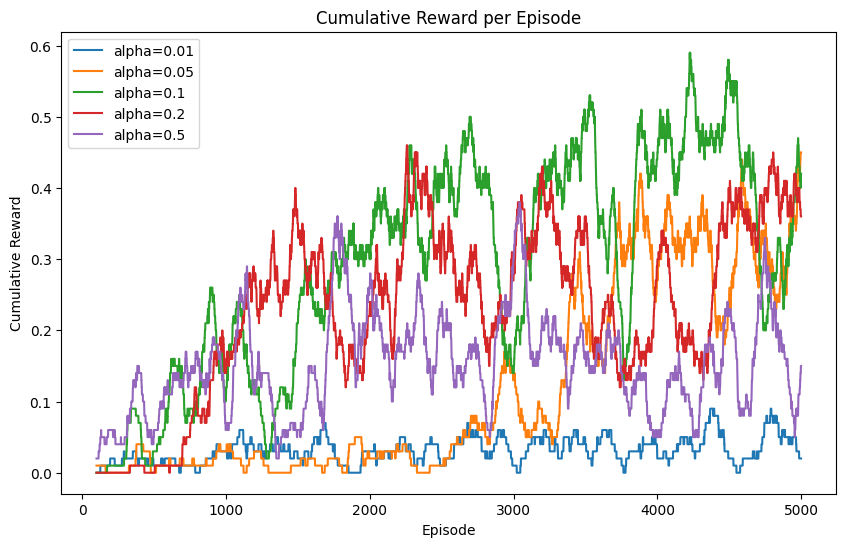

In [ ]:
alphas = [.01, .05, .1, .2, .5]
N=len(alphas)

plt.figure(figsize=(10, 6))

i=0
for a in alphas:
      test_agent = DecayAgent(env, alpha=a, min_epsilon=0.01)
      rewards = run_experiment_episode_train(env, test_agent, nb_episode)
      window_size = 100
      moving_avg = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
      i +=1
      plt.plot(range(window_size - 1, len(rewards)), moving_avg, label=f'alpha={a}')

plt.title(f'Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

In [ ]:
new_agent = Agent(env, epsilon=.05, alpha=.05)
new_agent_decay = DecayAgent(env, alpha=.1, min_epsilon=0.01)

rewards = run_experiment_episode_train(env, new_agent, nb_episode)
rewards_decay = run_experiment_episode_train(env, new_agent_decay, nb_episode)

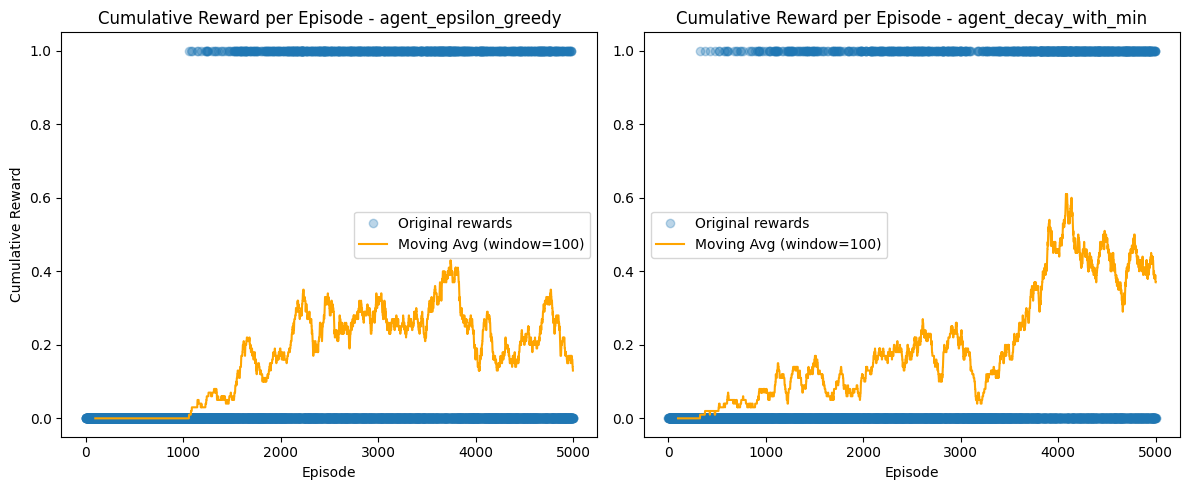

In [ ]:
window_size = 100
moving_avg_egreedy = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
moving_avg_decay = np.convolve(rewards_decay, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(rewards, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards)), moving_avg_egreedy, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - agent_epsilon_greedy')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.subplot(1,2,2)
plt.plot(rewards_decay, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_decay)), moving_avg_decay, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - agent_decay_with_min')
plt.xlabel('Episode')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(np.argmax(new_agent.q, axis=1))

print(np.argmax(new_agent_decay.q, axis=1))

[0 1 3 2 2 2 1 1 1 3 2 3 1 2 0 2 3 3 0 3 2 3 1 2 2 3 3 1 0 2 2 1 2 3 3 0 2
 1 3 1 0 1 0 2 3 0 2 2 1 0 1 0 1 2 3 2 1 3 0 3 2 3 2 3]
[3 2 2 1 2 1 2 1 3 3 3 3 2 2 2 2 0 3 0 3 2 3 1 2 0 0 3 1 0 3 2 2 0 3 3 3 2
 1 3 2 0 1 2 3 3 0 1 2 0 3 1 0 1 2 0 2 3 1 0 1 1 3 1 3]


In [ ]:
class Agent_final:
    def __init__(self, env):
        self.env = env
        self.policy = [3, 2, 2, 1, 2, 1, 2, 1, 3, 3, 3, 3, 2, 2, 2, 2, 0, 3, 0, 3, 2, 3, 1, 2, 0, 0, 3, 1, 0,
                       3, 2, 2, 0, 3, 3, 3, 2, 1, 3, 2, 0, 1, 2, 3, 3, 0, 1, 2, 0, 3, 1, 0, 1, 2, 0, 2, 3, 1, 0, 1, 1, 3, 1, 3]

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        action = self.policy[observation]
        return action

### Before submit
Test that your agent has the right attributes

In [ ]:
env = gym.make('FrozenLake-v1', map_name="8x8")
agent = Agent_final(env)

observation, _ = env.reset()
reward, terminated, truncated, info = None, False, False, None
rewards = []
while not (terminated or truncated):
    action = agent.choose_action(observation, reward=reward, terminated=terminated, truncated=truncated, info=info)
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
print(f'Cumulative Reward: {sum(rewards)}')

Cumulative Reward: 1.0


In [ ]:
nb_run = 10
rewards = []

for i in range(nb_run):
    observation, _ = env.reset()
    reward, terminated, truncated, info = None, False, False, None
    while not (terminated or truncated):
        action = agent.choose_action(observation, reward=reward, terminated=terminated, truncated=truncated, info=info)
        observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
print(f'Mean Reward: {np.mean(rewards)}')

Mean Reward: 0.8
